In [1]:
from mystatsfunctions import OLSE,LMoments

import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sn

# Ordinary least square estimator (OLSE)

# L-moments (LMoments)

#### comparing L-moments with `scipy.stats.distn.fit`

GEV

In [2]:
## generate multiple samples of the same underlying population:
true_k = -0.1
true_X = 0
true_alph = 1
gev_samples = stats.genextreme(true_k,true_X,true_alph).rvs(100000).reshape(100,1000)

In [3]:
## use LMoments to fit these samples:
lmom = LMoments.gev()
print('L-moments time:')
%time lmom.fit(gev_samples)

## use stats.fit
print('\nMLE time')
%time sp_mle_params = np.array([stats.genextreme.fit(x) for x in gev_samples.T])

L-moments time:
CPU times: user 32.2 ms, sys: 5.61 ms, total: 37.8 ms
Wall time: 40.9 ms

MLE time
CPU times: user 2min 1s, sys: 327 ms, total: 2min 1s
Wall time: 2min 1s


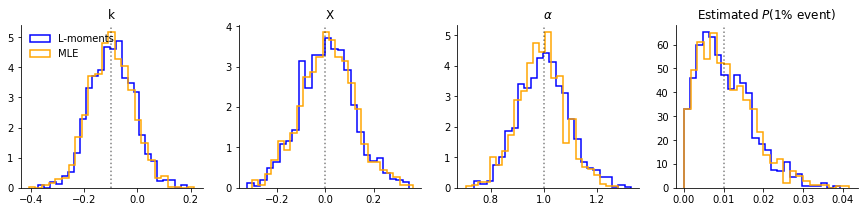

In [4]:
## plot parameter estimates:
fig,ax = plt.subplots(1,4,figsize=(15,3))
param_names = ['k','X',r'$\alpha$']
truth = [true_k,true_X,true_alph]

for i in np.arange(3):
    ax[i].hist(list(lmom.__dict__.values())[i],color='blue',label='L-moments',histtype='step',bins=25,linewidth=1.5,density=True)
    ax[i].hist(sp_mle_params[:,i],color='orange',label='MLE',histtype='step',bins=25,linewidth=1.5,density=True)
    ax[i].axvline(truth[i],color='k',alpha=0.5,ls=':')
    ax[i].set_title(param_names[i])
#     ax[i].set_ylim(0,6.5)

    
## and plot the 1 % event estimates:
true_1 = stats.genextreme(true_k,true_X,true_alph).ppf(0.99)
lmom_estimates = 1-lmom.cdf(true_1)
sp_mle_estimates = 1-sp.stats.genextreme(*sp_mle_params.T).cdf(true_1)

ax[3].hist(lmom_estimates,color='blue',label='L-moments',histtype='step',bins=25,linewidth=1.5,density=True)
ax[3].hist(sp_mle_estimates,color='orange',label='MLE',histtype='step',bins=25,linewidth=1.5,density=True)
ax[3].axvline(0.01,color='k',alpha=0.5,ls=':')
ax[3].set_title('Estimated $P$(1% event)')

ax[0].legend(frameon=False,loc='upper left')
sn.despine()

GLo

Note scipy's generalised logistic distribution is of a different form to the Hosking one used here.

In [5]:
## generate multiple samples of the same underlying population:
true_k = 0.1
true_X = 0
true_alph = 1
glo_samples = stats.genlogistic(true_k,true_X,true_alph).rvs(100000).reshape(100,1000)

In [6]:
## use LMoments to fit these samples:
lmom = LMoments.glo()
print('L-moments time:')
%time lmom.fit(glo_samples)

## use stats.fit
print('\nMLE time')
%time sp_mle_params = np.array([stats.genlogistic.fit(x) for x in glo_samples.T])

L-moments time:
CPU times: user 39.1 ms, sys: 0 ns, total: 39.1 ms
Wall time: 38.8 ms

MLE time
CPU times: user 1min 7s, sys: 83.8 ms, total: 1min 7s
Wall time: 1min 7s


/home/nick/Documents/mystatsfunctions/mystatsfunctions/LMoments.py:186: RuntimeWarning: invalid value encountered in power
  
/home/nick/miniconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:2187: RuntimeWarning: overflow encountered in exp
  Cx = (1+np.exp(-x))**(-c)


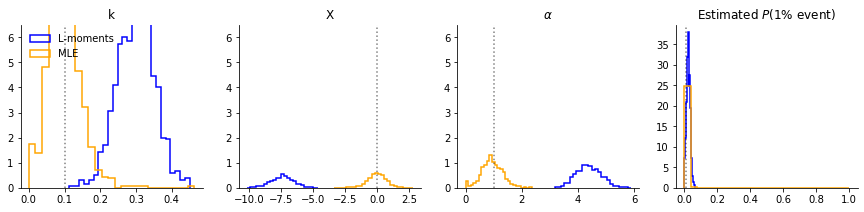

In [7]:
## plot parameter estimates:
fig,ax = plt.subplots(1,4,figsize=(15,3))
param_names = ['k','X',r'$\alpha$']
truth = [true_k,true_X,true_alph]

for i in np.arange(3):
    ax[i].hist(list(lmom.__dict__.values())[i],color='blue',label='L-moments',histtype='step',bins=25,linewidth=1.5,density=True)
    ax[i].hist(sp_mle_params[:,i],color='orange',label='MLE',histtype='step',bins=25,linewidth=1.5,density=True)
    ax[i].axvline(truth[i],color='k',alpha=0.5,ls=':')
    ax[i].set_title(param_names[i])
    ax[i].set_ylim(0,6.5)

    
## and plot the 1 % event estimates:
true_1 = stats.genlogistic(true_k,true_X,true_alph).ppf(0.99)
lmom_estimates = 1-lmom.cdf(true_1)
sp_mle_estimates = 1-sp.stats.genlogistic(*sp_mle_params.T).cdf(true_1)

ax[3].hist(lmom_estimates,color='blue',label='L-moments',histtype='step',bins=25,linewidth=1.5,density=True)
ax[3].hist(sp_mle_estimates,color='orange',label='MLE',histtype='step',bins=25,linewidth=1.5,density=True)
ax[3].axvline(0.01,color='k',alpha=0.5,ls=':')
ax[3].set_title('Estimated $P$(1% event)')

ax[0].legend(frameon=False,loc='upper left')
sn.despine()

GPD

Shape parameter defined as the negative of the scipy parameter

In [8]:
## generate multiple samples of the same underlying population:
true_k = -0.1
true_X = 0
true_alph = 1
gpd_samples = stats.genpareto(true_k,true_X,true_alph).rvs(100000).reshape(100,1000)

In [9]:
## use LMoments to fit these samples:
lmom = LMoments.gpd()
print('L-moments time:')
%time lmom.fit(gpd_samples)

## use stats.fit
print('\nMLE time')
%time sp_mle_params = np.array([stats.genpareto.fit(x) for x in gpd_samples.T])

L-moments time:
CPU times: user 34.4 ms, sys: 60 µs, total: 34.5 ms
Wall time: 33.5 ms

MLE time
CPU times: user 3min 25s, sys: 448 ms, total: 3min 26s
Wall time: 3min 27s


/home/nick/Documents/mystatsfunctions/mystatsfunctions/LMoments.py:271: RuntimeWarning: invalid value encountered in power
  


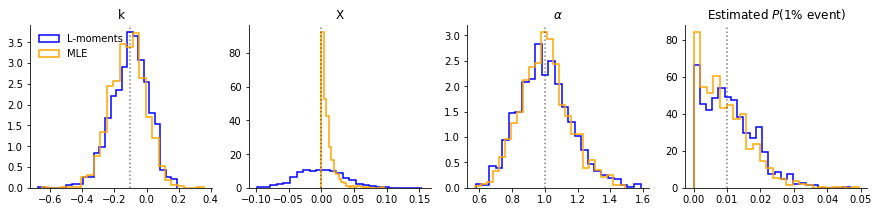

In [10]:
## plot parameter estimates:
fig,ax = plt.subplots(1,4,figsize=(15,3))
param_names = ['k','X',r'$\alpha$']
truth = [true_k,true_X,true_alph]

for i in np.arange(3):
    ax[i].hist(list(lmom.__dict__.values())[i]*[-1,1,1][i],color='blue',label='L-moments',histtype='step',bins=25,linewidth=1.5,density=True)
    ax[i].hist(sp_mle_params[:,i],color='orange',label='MLE',histtype='step',bins=25,linewidth=1.5,density=True)
    ax[i].axvline(truth[i],color='k',alpha=0.5,ls=':')
    ax[i].set_title(param_names[i])
#     ax[i].set_ylim(0,6.5)

    
## and plot the 1 % event estimates:
true_1 = stats.genpareto(true_k,true_X,true_alph).ppf(0.99)
lmom_estimates = 1-lmom.cdf(true_1)
sp_mle_estimates = 1-sp.stats.genpareto(*sp_mle_params.T).cdf(true_1)

ax[3].hist(lmom_estimates,color='blue',label='L-moments',histtype='step',bins=25,linewidth=1.5,density=True)
ax[3].hist(sp_mle_estimates,color='orange',label='MLE',histtype='step',bins=25,linewidth=1.5,density=True)
ax[3].axvline(0.01,color='k',alpha=0.5,ls=':')
ax[3].set_title('Estimated $P$(1% event)')

ax[0].legend(frameon=False,loc='upper left')
sn.despine()

norm

In [11]:
## generate multiple samples of the same underlying population:
true_X = 0
true_alph = 1
norm_samples = stats.norm(true_X,true_alph).rvs(100000).reshape(100,1000)

In [12]:
## use LMoments to fit these samples:
lmom = LMoments.norm()
print('L-moments time:')
%time lmom.fit(norm_samples)

## use stats.fit
print('\nMLE time')
%time sp_mle_params = np.array([stats.norm.fit(x) for x in norm_samples.T])

L-moments time:
CPU times: user 27.4 ms, sys: 0 ns, total: 27.4 ms
Wall time: 24.9 ms

MLE time
CPU times: user 102 ms, sys: 0 ns, total: 102 ms
Wall time: 102 ms


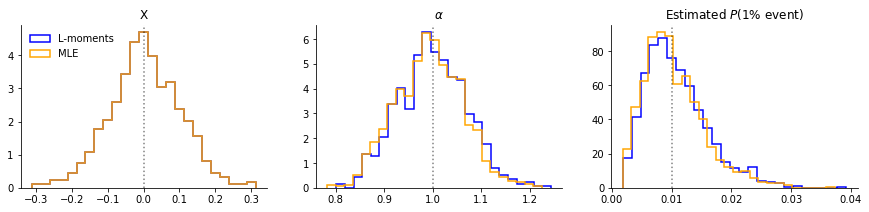

In [13]:
## plot parameter estimates:
fig,ax = plt.subplots(1,3,figsize=(15,3))
param_names = ['X',r'$\alpha$']
truth = [true_X,true_alph]

for i in np.arange(2):
    ax[i].hist(list(lmom.__dict__.values())[i],color='blue',label='L-moments',histtype='step',bins=25,linewidth=1.5,density=True)
    ax[i].hist(sp_mle_params[:,i],color='orange',label='MLE',histtype='step',bins=25,linewidth=1.5,density=True)
    ax[i].axvline(truth[i],color='k',alpha=0.5,ls=':')
    ax[i].set_title(param_names[i])
#     ax[i].set_ylim(0,6.5)
    
## and plot the 1 % event estimates:
true_1 = stats.norm(true_X,true_alph).ppf(0.99)
lmom_estimates = 1-lmom.cdf(true_1)
sp_mle_estimates = 1-sp.stats.norm(*sp_mle_params.T).cdf(true_1)

ax[-1].hist(lmom_estimates,color='blue',label='L-moments',histtype='step',bins=25,linewidth=1.5,density=True)
ax[-1].hist(sp_mle_estimates,color='orange',label='MLE',histtype='step',bins=25,linewidth=1.5,density=True)
ax[-1].axvline(0.01,color='k',alpha=0.5,ls=':')
ax[-1].set_title('Estimated $P$(1% event)')

ax[0].legend(frameon=False,loc='upper left')
sn.despine()

## Sandbox

testing different shape signs for GEV / GLO / GPD